# Global Root-zone moisture Analysis & Forecasting System (GRAFS) <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:**
[GRAFS](http://dap.nci.org.au/thredds/remoteCatalogService?catalog=http://dapds00.nci.org.au/thredds/catalog/ub8/global/GRAFS/catalog.xml), 
[ERA5](https://registry.opendata.aws/ecmwf-era5/)

*Both datasets are external to the Digital Earth Africa platform.*

## Background

Soil moisture is a measure of water stored in the soil zone that is accessible to plant roots, making it a major contributing factor to plant health and crop yield.

The Global Root-zone moisture Analysis & Forecasting System (GRAFS) is produced by the [ANU Centre for Water and Landscape Dynamics](www.wald.anu.edu.au).
The model estimates the surface (0-5 cm) and root-zone (0-1 m) soil moisture at 10 km spatial resolution globally, using the precipitation measured by the Global Precipitation Measurement (GPM) mission and through assimilation of the soil moisture product from the [Soil Moisture Active/Passive](https://smap.jpl.nasa.gov/mission/description/) (SMAP) mission.

This product is regularly updated and made available through National Computational Infrastructure's open access THREDDS data server.

For more information on this product, contact [Luigi Renzullo](mailto:Luigi.Renzullo@anu.edu.au) and [Siyuan Tian](mailto:siyuan.tian@anu.edu.au).

## Description

This notebook demonstrates the following steps:
1. Retrieval of surface and root-zone wetness through NCI's THREDDS OPeNDAP service
2. Compare soil moisture to precipitation data from ERA5

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import datacube

import sys
sys.path.append("../Scripts")
from deafrica_load_era5 import load_era5

### Analysis parameters

Define location and time period of interest.
The time period is chosen to be less than a year to limit ERA5 data download.

In [2]:
# Define the analysis region (Lat-Lon box)

# Il Ngwesi region of Kenya - Rhino Project
lat = (0.412, 0.266)
lon = (37.32, 37.40)

# High Energy Stereoscopic System site near Windhoek Namibia
#lat = (-23.28, -23.26)
#lon = (16.49, 16.51)

# Define the time window
time = '2018-07-01', '2019-05-31'

## Retrieval of surface and root-zone wetness

> `Surface wetness` is measured relative to wettest condition recorded for a location.

> `Rootzone Soil Water Index` is derived from surface relative wetness

In [3]:
# function to load soil moisture data

def load_soil_moisture(lat, lon, time, product = 'surface', grid = 'nearest'):
    product_baseurl = 'http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/'
    assert product in ['surface', 'rootzone'], 'product parameter must be surface or root-zone'
    # lat, lon grid
    if grid == 'nearest':
        # select lat/lon range from data; snap to nearest grid
        lat_range, lon_range = None, None
    else:
        # define a grid that covers the entire area of interest
        lat_range = np.arange(np.max(np.ceil(np.array(lat)*10.+0.5)/10.-0.05), np.min(np.floor(np.array(lat)*10.-0.5)/10.+0.05)-0.05, -0.1)
        lon_range = np.arange(np.min(np.floor(np.array(lon)*10.-0.5)/10.+0.05), np.max(np.ceil(np.array(lon)*10.+0.5)/10.-0.05)+0.05, 0.1)
    # split time window into years
    day_range = np.array(time).astype("M8[D]")
    year_range = np.array(time).astype("M8[Y]")
    if product == 'surface':
        product_name = 'GRAFS_TopSoilRelativeWetness_'
    else: product_name = 'GRAFS_RootzoneSoilWaterIndex_'
    datasets = []
    for year in np.arange(year_range[0], year_range[1]+1, np.timedelta64(1, 'Y')):
        start = np.max([day_range[0], year.astype("M8[D]")])
        end = np.min([day_range[1], (year+1).astype("M8[D]")-1])
        product_url = product_baseurl + product_name +'%s.nc'%str(year)
        print(product_url)
        # data is loaded lazily through OPeNDAP
        ds = xr.open_dataset(product_url)
        if lat_range is None:
            # select lat/lon range from data if not specified; snap to nearest grid
            test = ds.sel(lat=lat, lon=lon, method='nearest')
            lat_range = slice(test.lat.values[0], test.lat.values[1])
            lon_range = slice(test.lon.values[0], test.lon.values[1])
        # slice before return
        ds = ds.sel(lat=lat_range, lon=lon_range, time=slice(start, end)).compute()
        datasets.append(ds)
    return xr.merge(datasets)

In [4]:
# Retrieve surface soil moisture using query parameters
surface_wetness = load_soil_moisture(lat, lon, time, grid='nearest')

http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_TopSoilRelativeWetness_2018.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_TopSoilRelativeWetness_2019.nc


In [5]:
# retrieve rootzone soil moisture using query parameters
rootzone_wetness = load_soil_moisture(lat, lon, time, product='rootzone', grid='nearest')

http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_RootzoneSoilWaterIndex_2018.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_RootzoneSoilWaterIndex_2019.nc


### Plot surface and root-zone wetness over time

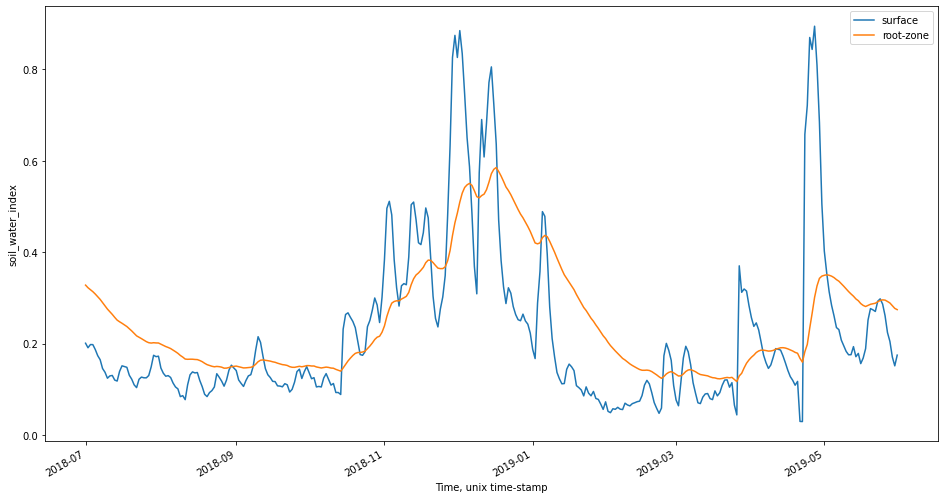

In [6]:
surface_wetness.relative_wetness.mean(['lat','lon']).plot(figsize=(16,8), label='surface');
rootzone_wetness.soil_water_index.mean(['lat','lon']).plot(label='root-zone');
plt.legend()

## Compare soil moisture to precipitation data from ERA5

The first cell will load the precipitation parameter, `precipitation_amount_1hour_Accumulation`, from ERA5. Depending on the size of your query, this step can take a few minutes to complete. Data will be stored in the folder `era5`.

In [7]:
# load precipitation data from ERA5
var_precipitation = 'precipitation_amount_1hour_Accumulation'
precipitation = load_era5(var_precipitation, lat, lon, time, reduce_func=np.sum, grid='nearest')

# Convert from Meters (m) to Millimeters (mm)
precipitation[var_precipitation]=precipitation[var_precipitation]*1000

### Plot soil moisture with precipitation

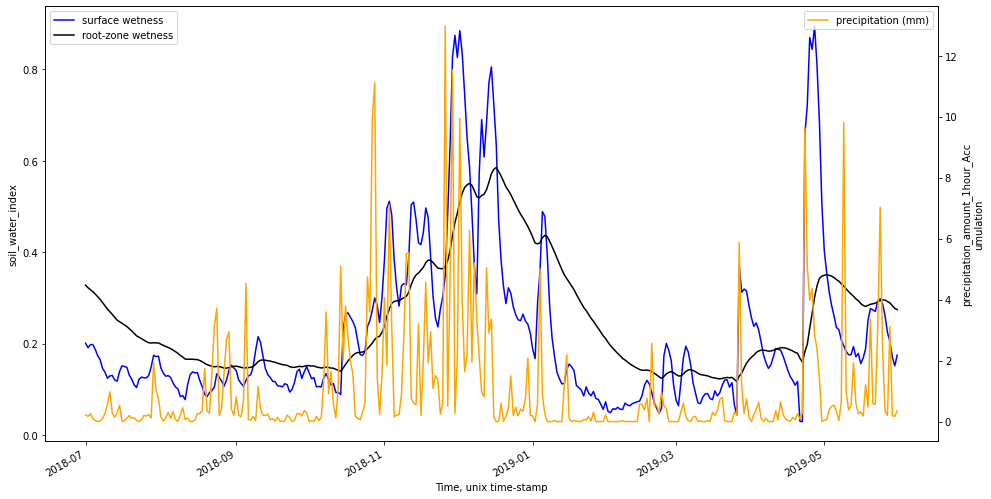

In [8]:
# plot soil moisture with precipitation

fig, ax1 = plt.subplots(figsize=(16,8))
ax2 = ax1.twinx()
surface_wetness.relative_wetness.mean(['lat','lon']).plot(ax = ax1, label = 'surface wetness', color = 'blue');
rootzone_wetness.soil_water_index.mean(['lat','lon']).plot(ax = ax1, label = 'root-zone wetness', color = 'black');
precipitation[var_precipitation].mean(['lat','lon']).plot(ax = ax2, label = 'precipitation (mm)', color = 'orange');
ax1.legend()
ax2.legend()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** April 2020

**Compatible datacube version:** 

In [9]:
print(datacube.__version__)

1.7+262.g1cf3cea8


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)